In [1]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
#设置全局中文字体
font_path = '/kaggle/input/chinese-fonts/SourceHanSansSC-Regular.otf'
chinese_font = FontProperties(fname=font_path)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 读取数据
df = pd.read_csv('/kaggle/input/lending-club-data/loan_data_essential.csv', low_memory=False)

def preprocess_data(df):
    # 创建副本以免影响原数据
    df = df.copy()
    
    # 1. 目标变量定义
    bad_status = ['Late (31-120 days)', 'Late (16-30 days)', 'Charged Off', 'Default']
    df['is_risk'] = df['loan_status'].apply(lambda x: 1 if x in bad_status else 0)
    
    # 2. 处理 'term' (贷款期限) 
    # 先提取为字符串，可能有 NaN
    df['term_numeric'] = df['term'].str.extract('(\d+)')
    # 必须先删除 term_numeric 为空的行，才能转整数
    df = df.dropna(subset=['term_numeric'])
    # 现在可转为整数
    df['term_numeric'] = df['term_numeric'].astype(int)
    
    # 3. 处理 'emp_length' (工作年限)
    # 提取数字，转换为 float (float 可以允许 NaN存在)
    df['emp_length'] = df['emp_length'].str.extract('(\d+)').astype(float)
    
    # 4. 删除关键信息缺失的行
    # 如果年收入、DTI 或 工作年限 缺失，无法用于建模
    df = df.dropna(subset=['emp_length', 'annual_inc', 'dti'])
    
    # 5. 异常值处理
    df = df[(df['annual_inc'] > 1000) & (df['annual_inc'] < 300000)]
    df = df[df['dti'] <= 60]
    
    return df

# 执行清洗
df_clean = preprocess_data(df)
print(f"清洗后数据量: {len(df_clean)}")
print(f"风险样本比例: {df_clean['is_risk'].mean():.2%}")

清洗后数据量: 922301
风险样本比例: 13.21%


In [3]:
def feature_engineering(df):
    df = df.copy()
    
    # 2.1 核心压力指标：月供收入比 (Installment Ratio)
    # 逻辑：每月的还款额占月收入的比例。比例越高，生活压力越大，违约概率越高。
    df['installment_ratio'] = df['installment'] / (df['annual_inc'] / 12)
    
    # 2.2 信用等级量化
    # 逻辑：将 A-G 转换为 1-7，便于模型处理。强特征。
    grade_map = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7}
    df['grade_score'] = df['grade'].map(grade_map)
    
    # 2.3 特征筛选
    # 只保留用于建模的核心数值特征
    features = ['loan_amnt', 'int_rate', 'dti', 'annual_inc', 
                'installment_ratio', 'grade_score', 'term_numeric', 'emp_length', 'is_risk']
    return df[features]

df_features = feature_engineering(df_clean)

# 检查是否有无限值（防止除以0错误）
df_features = df_features.replace([np.inf, -np.inf], np.nan).dropna()
df_features.head()

,loan_amnt,int_rate,dti,annual_inc,installment_ratio,grade_score,term_numeric,emp_length,is_risk
0,3600.0,13.99,5.91,55000.0,0.026843,3,36,10.0,0
1,24700.0,11.99,16.06,65000.0,0.151436,3,36,10.0,0
2,20000.0,10.78,10.78,63000.0,0.082411,2,60,10.0,0
3,35000.0,14.85,17.06,110000.0,0.090535,3,60,10.0,0
4,10400.0,22.45,25.37,104433.0,0.033312,6,60,3.0,0


【关键修正】贷款利率与风险的真实相关系数 r = 0.2139
【关键修正】月供比的80%分位点阈值: 0.1124

不同压力组的违约率对比:
pressure_group
High    0.177074
Low     0.120850
Name: is_risk, dtype: float64
高压力组风险是低压力组的 1.47 倍


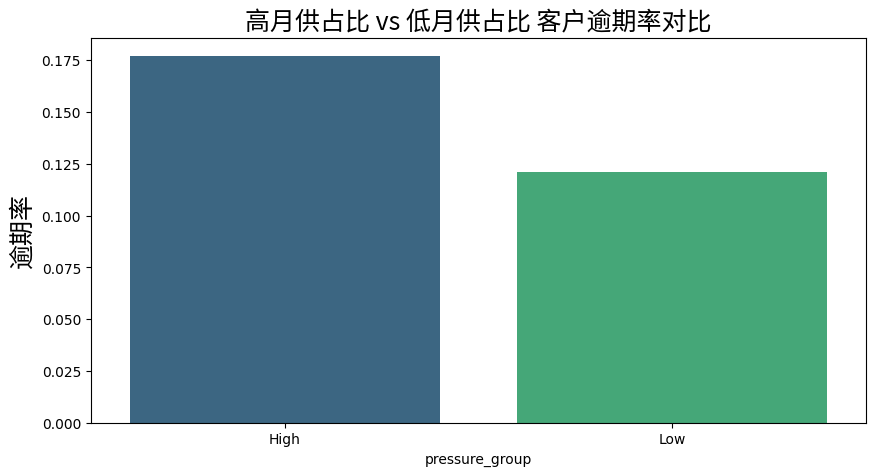

In [4]:
# 3.1 修正：计算真实的相关系数
corr_matrix = df_features.corr(numeric_only=True) 

# 获取利率与风险的相关系数
real_r = corr_matrix.loc['int_rate', 'is_risk']
print(f"【关键修正】贷款利率与风险的真实相关系数 r = {real_r:.4f}")

# 3.2 修正：月供比阈值分析 (Threshold Analysis)
# 计算80%分位数 (Top 20% 的高压人群)
quantile_80 = df_features['installment_ratio'].quantile(0.8)
print(f"【关键修正】月供比的80%分位点阈值: {quantile_80:.4f}")

# 创建分组列（生成 'High'/'Low' 字符串，上面的 corr 计算要加 numeric_only=True）
df_features['pressure_group'] = df_features['installment_ratio'].apply(
    lambda x: 'High' if x > quantile_80 else 'Low'
)

# 计算不同组的违约率
group_risk = df_features.groupby('pressure_group')['is_risk'].mean()
print("\n不同压力组的违约率对比:")
print(group_risk)

# 计算风险倍数
risk_multiplier = group_risk['High'] / group_risk['Low']
print(f"高压力组风险是低压力组的 {risk_multiplier:.2f} 倍")

# 3.3 可视化验证
plt.figure(figsize=(10, 5))
sns.barplot(x=group_risk.index, y=group_risk.values, palette='viridis')
plt.title('高月供占比 vs 低月供占比 客户逾期率对比',fontproperties=chinese_font,size=18)
plt.ylabel('逾期率',fontproperties=chinese_font,size=18)
plt.show()

In [5]:
from scipy.stats import chi2_contingency

# 生成列联表
contingency_table = pd.crosstab(df_features['pressure_group'], df_features['is_risk'])
print("\n列联表 (样本数):")
print(contingency_table)

# 卡方检验
chi2, p_val, dof, expected = chi2_contingency(contingency_table)
print(f"\n卡方统计量: {chi2:.2f}")
print(f"P值: {p_val:.4e}") # 科学计数法

if p_val < 0.05:
    print("结论：P值小于0.05，拒绝原假设。说明【月供收入比】与【违约风险】存在显著的统计学关联。")
else:
    print("结论：关联不显著。")


列联表 (样本数):
is_risk              0      1
pressure_group               
High            151797  32663
Low             648673  89168

卡方统计量: 4068.38
P值: 0.0000e+00
结论：P值小于0.05，拒绝原假设。说明【月供收入比】与【违约风险】存在显著的统计学关联。


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

# 5.1 准备数据
X = df_features[['dti', 'term_numeric', 'installment_ratio', 'grade_score', 'annual_inc', 'int_rate']]
y = df_features['is_risk']

# 划分数据集 (80% 训练, 20% 测试)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 5.2 训练模型 (参数调优版)
# max_depth=10: 让树长得深一点，捕捉复杂逻辑
# n_estimators=200: 增加树的数量，提高稳定性
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,  
    min_samples_leaf=20, # 防止过拟合
    class_weight='balanced', # 关键：告诉模型坏人更重要
    random_state=42,
    n_jobs=-1
)

print("模型训练中...")
rf_model.fit(X_train, y_train)

# 5.3 模型预测
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]
y_pred_class = rf_model.predict(X_test)

# 5.4 评估指标
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"\n模型 AUC 分数: {auc_score:.3f}")
print("\n分类报告:")
print(classification_report(y_test, y_pred_class))

# 5.5 特征重要性
importances = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\n特征重要性排序:")
print(importances)

模型训练中...

模型 AUC 分数: 0.720

分类报告:
              precision    recall  f1-score   support

           0       0.93      0.61      0.74    160095
           1       0.21      0.70      0.33     24366

    accuracy                           0.62    184461
   macro avg       0.57      0.66      0.53    184461
weighted avg       0.84      0.62      0.68    184461


特征重要性排序:
grade_score          0.424748
int_rate             0.407792
installment_ratio    0.066953
dti                  0.041612
term_numeric         0.032845
annual_inc           0.026050
dtype: float64
